## Installing and Imports libraries

In [1]:
#!pip3 install scikit-image

In [1]:
# Imports
#import random
import numpy as np
import pandas as pd
import os
import sys
#import codecs
import PIL
import cv2
import re
#import string

#import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet
from pymorphy2 import MorphAnalyzer

# Input data files are available in the read-only "../input/" directory

# ML libraries
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# keras
import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import efficientnet.tfkeras as efn
#from keras_bert import load_trained_model_from_checkpoint
import albumentations

# plt
import matplotlib.pyplot as plt

# set not big default graphs
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python         :', sys.version.split('\n')[0])
print('Numpy          :', np.__version__)
print('Tensorflow     :', tf.__version__)
print('Albumentations :', albumentations.__version__)

Python         : 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
Numpy          : 1.24.2
Tensorflow     : 2.9.1
Albumentations : 1.3.0


In [2]:
# Imports of local libs
sys.path.insert(1, '../')

from utils.paths import create_paths
from utils.read_config import config_reader

from utils.models import MyNaiveModel, define_cat_boost, SimpleSeqNN, MultiSeqNN

from utils.nbook_functions import mape_func, create_preproc_data, concat_train_test
from utils.nbook_functions import plot_history_loss, save_best_model, show_sample_imgs
from utils.nbook_functions import get_image_array, show_sample_augmentations

from utils.eda_functions import make_unzip, pre_an_types_feat, prints_types_feat

from utils.keras_functions import callbacks, define_snn_optimizer, data_descr_to_nlp
from utils.keras_functions import define_mnn_optimizer

from utils.preprocess import preproc

In [3]:
# read defined params
config = config_reader('../config/data_config.json')
paths = create_paths(config)

# fix RANDOM_SEED for repeating results
RANDOM_SEED = config.RANDOM_SEED
np.random.seed(RANDOM_SEED)

## Reading Data

In [5]:
# unzip data
is_unzip = False
make_unzip(paths.PATH_TO_ZIP, paths.PATH_DATA, is_unzip=is_unzip)

Zip-archive "sf-dst-car-price-prediction-part2.zip" no need to unpack, to unpack change value of param "is_unzip" to "True"


In [6]:
# Reading '.cvs' data files
train = pd.read_csv(os.path.join(paths.PATH_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(paths.PATH_DATA, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# Let's look at the train data set columns
print(train.columns)

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')


In [7]:
train.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1772,седан,MERCEDES,чёрный,Состояние нового автомобиля.,5.5 LTR,585 N12,бензин,2900,2013,S_KLASSE_AMG,...,7100000.0,2016,1100165184,SEDAN AUTOMATIC 5.5,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый
4813,хэтчбек 5 дв.,AUDI,красный,При покупке автомобиля:\n► Возможна покупка ав...,2.0 LTR,150 N12,бензин,224000,2004,A3,...,389000.0,2005,1099744048,HATCHBACK_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,передний,Левый


In [8]:
# Comparison of the number of columns in training and test datasets
print(f'Num train cols: {len(train.columns)}, ', f'Num test cols: {len(test.columns)}')
print(f'Col not in test: {set(train.columns) - set(test.columns)}')

# Col with name 'price' - its a target

Num train cols: 22,  Num test cols: 21
Col not in test: {'price'}


In [9]:
# print info about train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [ ]:
# Automatic types of test features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(test)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'sell_id', 'vehicleConfiguration', 'Владение']


### Types of features 


<details>
<summary> Display types of all used features </summary> <br>

* bodyType - categorical
* brand - categorical
* color - categorical
* description - text
* engineDisplacement - numeric, represented as text
* enginePower - numeric, represented as text
* fuelType - categorical
* mileage - numeric
* modelDate - numeric or categorical with large num categories
* model_info - categorical
* name - categorical, needs to reduce nums of unique values
* numberOfDoors - categorical
* price - numeric, target
* productionDate - numeric or categorical with large num categories
* sell_id - text, link to images (images are available at the addresses based on sell_id)
* vehicleConfiguration - don't use (cause it's a combination of other columns)
* vehicleTransmission - categorical
* Владельцы - categorical
* Владение - numeric, represented as text
* ПТС - binary
* Привод - categorical
* Руль - binary

Note: Conclusions were done using manual analysis of train and test DataFrames. 
</details>

## Model 1: the "naive" model
This Model 1 will predict the average price by model name and year of manufacture of car.  
We will compare other models with it.

In [ ]:
# splitting of data by train and test
data_train, data_test = train_test_split(train, test_size=0.13, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# predicts of "naive" model
predicts = MyNaiveModel(data_train, data_test).predicts

# evaluating the accuracy (mape metric)
print("The accuracy of the naive model according to the MAPE metric: ",
      f"{(mape_func(data_test['price'], predicts['price'].values))*100:0.2f}%")

The accuracy of the naive model according to the MAPE metric:  18.02%


## Model 2: CatBoostRegressor

In [ ]:
# load and prepare data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)

tabular preproc done
data preproc finish


In [ ]:
model = define_cat_boost(config)

model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=config.cat_verbose_eval,
          use_best_model=True,
          #metric_period
          #plot=True
          )

test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape_func(y_test, test_predict_catboost))*100:0.2f}%")

0:	learn: 0.6232694	test: 0.6118137	best: 0.6118137 (0)	total: 194ms	remaining: 5h 23m 54s
100:	learn: 0.2081057	test: 0.2208584	best: 0.2208584 (100)	total: 4.72s	remaining: 1h 17m 48s
200:	learn: 0.1369062	test: 0.1536253	best: 0.1536253 (200)	total: 9.49s	remaining: 1h 18m 34s
300:	learn: 0.1197003	test: 0.1392127	best: 0.1392127 (300)	total: 13.4s	remaining: 1h 13m 55s
400:	learn: 0.1126968	test: 0.1344695	best: 0.1344695 (400)	total: 17.2s	remaining: 1h 11m 5s
500:	learn: 0.1072988	test: 0.1309746	best: 0.1309746 (500)	total: 21s	remaining: 1h 9m 33s
600:	learn: 0.1031736	test: 0.1281825	best: 0.1281825 (600)	total: 25s	remaining: 1h 8m 48s
700:	learn: 0.0997879	test: 0.1264476	best: 0.1264476 (700)	total: 29s	remaining: 1h 8m 22s
800:	learn: 0.0967942	test: 0.1247807	best: 0.1247807 (800)	total: 32.9s	remaining: 1h 7m 59s
900:	learn: 0.0942712	test: 0.1233878	best: 0.1233878 (900)	total: 36.9s	remaining: 1h 7m 33s
1000:	learn: 0.0920353	test: 0.1223449	best: 0.1223355 (988)	total

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('../catboost_submission.csv', index=False)

## Model 3: Tabular NN

### Simple Dense NN

In [10]:
# load and prepare table data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
config.snn_input_shape = X_train.shape[1]

tabular preproc done
data preproc finish


In [11]:
model = SimpleSeqNN(config).build_model()

optimizer = define_snn_optimizer(config)
model.compile(loss=config.snn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.snn_metric_compile])

callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit(X_train, 
                    y_train,
                    batch_size=config.snn_batch_size,
                    epochs=config.snn_epochs,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=config.snn_verbose,
                    )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 99.9934 - MAPE: 99.9934
Epoch 1: val_MAPE improved from inf to 99.98875, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 4s 232ms/step - loss: 99.9934 - MAPE: 99.9934 - val_loss: 99.9888 - val_MAPE: 99.9888 - lr: 0.0100
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 99.1954 - MAPE: 99.1954
Epoch 2: val_MAPE improved from 99.98875 to 98.66371, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3s 212ms/step - loss: 99.1954 - MAPE: 99.1954 - val_loss: 98.6637 - val_MAPE: 98.6637 - lr: 0.0100
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 89.6355 - MAPE: 89.6355
Epoch 3: val_MAPE improved from 98.66371 to 85.68061, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 2s 191ms/step - loss: 89.6355 - MAPE: 89.6355 - val_loss: 85.6806 - val_MAPE: 85.

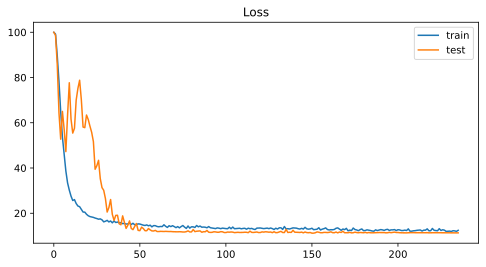

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 0s 9ms/step
TEST mape: 11.19%


In [12]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.snn_best_weights_name,
                config.snn_best_model_name)

# test predict
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape_func(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

In [13]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('../nn1_submission.csv', index=False)

53/53 [==============================] - 1s 11ms/step


## Model 4: NLP + Multiple Input

### Load data and Work with data.description

In [5]:
# load and prepare table data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
list_inds = [X_train.index, X_test.index, X_sub.index]
config.mnn_input_shape = X_train.shape[1]

tabular preproc done
data preproc finish


In [6]:
# load and prepare feature 'description' to tokenize
data_descr = concat_train_test(paths).description
data_descr.sample(3)

5194    МБ-Беляево — официальный дилер «Мерседес-Бенц»...
3724    Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...
4518    Машина в хорошем состоянии. Сел и поехал. Влож...
Name: description, dtype: object

In [7]:
# tokenize feature 'description'
text_train_sequences, text_test_sequences, \
    text_sub_sequences, tokenize = data_descr_to_nlp(data_descr, config, list_inds)
# text before and after preparing
print(data_descr.iloc[0], end='\n\n')
print(text_train_sequences[0])

Всем привет!

Продам эксклюзивный проект 124 универсал 300TE-24 SportLine

Модель 124.091 300 TE-24
Двигатель 104.980
Трансмиссия 722.359
Цвет кузова 040 (черный)
Отделка салона 271 (Кожа черная / "антрацит")

Опции:
211 Автоматическая блокировка дифференциала (ASD)
240 Индикатор внешней температуры
244 Спортивные сиденья спереди
281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП
291 Подушка безопасности для водителя и переднего пассажира
300 Дополнительный бардачок в вещевом отсеке спереди
412 Люк с электроприводом и устройством подъёма
420 Автоматическая коробка передач, напольное исполнение
440 Темпомат (круиз-контроль)
538 Автоматическая антенна
541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)
570 Складной подлокотник спереди
586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей
598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)
650 Спортивная подвеска
673 АКБ уве

### Step 1: Creating MultiInputNN model (NLP+SimpleNN with one head) and 
### fit with LR=0.01

In [8]:
# Creating Multi Input NN
model = MultiSeqNN(config, tokenize).build_model()

# define optimizer
optimizer = define_mnn_optimizer(config.mnn_lr_step_1)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# define LR for callbacks function
config.LR = config.mnn_lr_step_1

# define callbacks list with LR
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 99.2528 - MAPE: 99.2528  
Epoch 1: val_MAPE improved from inf to 97.96981, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3876s 322s/step - loss: 99.2528 - MAPE: 99.2528 - val_loss: 97.9698 - val_MAPE: 97.9698 - lr: 0.0100
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 81.5054 - MAPE: 81.5054  
Epoch 2: val_MAPE improved from 97.96981 to 65.29369, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 4186s 351s/step - loss: 81.5054 - MAPE: 81.5054 - val_loss: 65.2937 - val_MAPE: 65.2937 - lr: 0.0100
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 52.8907 - MAPE: 52.8907  
Epoch 3: val_MAPE improved from 65.29369 to 49.69584, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3731s 308s/step - loss: 52.8907 - MAPE: 52.8907 - val_loss: 49.6958 - val_MAP

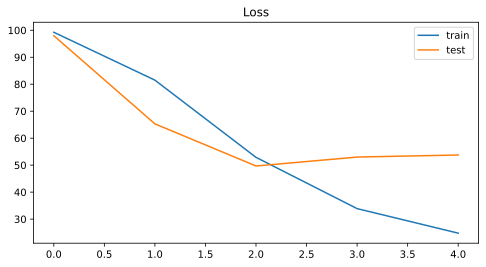

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 217s 8s/step
TEST mape: 49.70%


In [9]:
# plot history loss
plot_history_loss(history)

# load best weights model and save model
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_1,
                config.mnn_best_model_name_st_1)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 2: reduce LR from 0.01 to 0.005 and fit

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 36.0119 - MAPE: 36.0119  
Epoch 1: val_MAPE improved from inf to 44.35678, saving model to ..\data\best_models\best_weights.hdf5
12/12 [==============================] - 3848s 317s/step - loss: 36.0119 - MAPE: 36.0119 - val_loss: 44.3568 - val_MAPE: 44.3568 - lr: 0.0050
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 27.9801 - MAPE: 27.9801  
Epoch 2: val_MAPE did not improve from 44.35678
12/12 [==============================] - 3780s 315s/step - loss: 27.9801 - MAPE: 27.9801 - val_loss: 47.3326 - val_MAPE: 47.3326 - lr: 0.0050
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 23.7398 - MAPE: 23.7398  
Epoch 3: val_MAPE did not improve from 44.35678
12/12 [==============================] - 3612s 300s/step - loss: 23.7398 - MAPE: 23.7398 - val_loss: 49.0656 - val_MAPE: 49.0656 - lr: 0.0050
Epoch 4/5
12/12 [==============================] - ETA: 0s - loss: 21.2719 - MAPE: 21.2719  
Epo

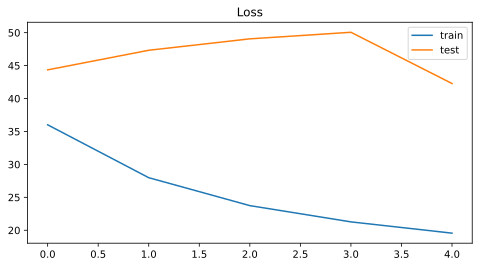

best weights and model of Simple Sequential Model saved
28/28 [==============================] - 193s 7s/step
TEST mape: 42.28%


In [10]:
# loading weights from step 1
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_1))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_2)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_2

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 2
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_2,
                config.mnn_best_model_name_st_2)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 3: reduce LR from 0.005 to 0.002 and fit

In [ ]:
# loading weights from step 2
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_2))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_3)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_3

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 3
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_3,
                config.mnn_best_model_name_st_3)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 4: reduce LR from 0.002 to 0.0002 and fit

In [ ]:
# loading weights from step 3
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_3))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_4)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_4

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 4
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_4,
                config.mnn_best_model_name_st_4)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 5: reduce LR from 0.0002 to 0.0001 and fit

In [ ]:
# loading weights from step 4
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_4))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_5)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_5

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 5
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_5,
                config.mnn_best_model_name_st_5)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 6: reduce LR from 0.0001 to 0.0000005 and fit

In [ ]:
# loading weights from step 5
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_5))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_6)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_6

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 6
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_6,
                config.mnn_best_model_name_st_6)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

### Step 7: reduce LR from 0.0000005 to 0.00000005 and fit

In [ ]:
# loading weights from step 6
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_6))

# define optimizer with reduced lr
optimizer = define_mnn_optimizer(config.mnn_lr_step_7)

# compile model
model.compile(loss=config.mnn_loss_compile, 
              optimizer=optimizer, 
              metrics=[config.mnn_metric_compile])

# reduce lr in LR param of config for callbacks functions
config.LR = config.mnn_lr_step_7

# define new callbacks list with reduced lr
callbacks_list = callbacks(paths.PATH_BEST_MODEL, config)

# fit
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=config.mnn_batch_size,
                    epochs=5, #config.mnn_epochs, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=config.mnn_verbose
                   )

# plot history loss
plot_history_loss(history)

# load best weights model and save model after fit step 7
save_best_model(model, paths,
                config.best_weights_name,
                config.mnn_best_weights_name_st_7,
                config.mnn_best_model_name_st_7)

# test predict
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape_func(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
# loading weights from step 7
model.load_weights(os.path.join(paths.PATH_MODELS, config.mnn_best_weights_name_st_7))

sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
#sample_submission['price'] = sub_predict_nn2[:,0]
#sample_submission.to_csv('nn2_submission.csv', index=False)

sample_submission['price'] = np.round(sub_predict_nn2[:,0],-4) # округляем до 4 знаков до запятой!!!
sample_submission.to_csv('nn2_submission_wth_round.csv', index=False)

## Model 5: Add picture

In [4]:
# load and prepare data to train
X_sub, X_train, X_test, y_train, y_test = create_preproc_data(config, paths)
list_inds = [X_train.index, X_test.index, X_sub.index]
config.mnn_input_shape = X_train.shape[1]

# load and prepare feature 'description' to tokenize
data_descr = concat_train_test(paths).description
data = concat_train_test(paths)

# tokenize feature 'description'
text_train_sequences, text_test_sequences, \
    text_sub_sequences, tokenize = data_descr_to_nlp(data_descr, config, list_inds)

tabular preproc done
data preproc finish


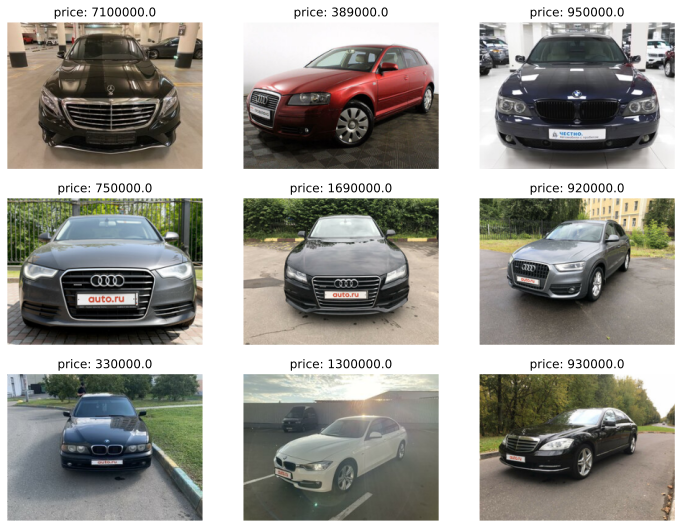

In [5]:
# looking for samples images and target (price)
show_sample_imgs(paths, n_samples=9)

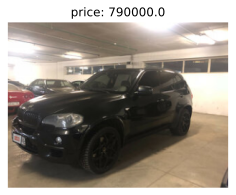

(320, 240)


In [6]:
# one sample image and it's size to understand how better to prepare and zip images
show_sample_imgs(paths, n_samples=1)

In [7]:
# add description
images_train = get_image_array(X_train.index, paths, config)
images_test = get_image_array(X_test.index, paths, config)
images_sub = get_image_array(X_sub.index, paths, config)

images shape (5812, 240, 320, 3) dtype uint8
images shape (869, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [8]:
# define augmentations
augmentation = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    #albumentations.ElasticTransform(p=0.25, alpha=1.0, sigma=10, alpha_affine=10, 
    #                                interpolation=1, border_mode=1, value=(0, 0, 0), 
    #                                mask_value=None, approximate=False),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.GaussNoise(p=0.25, var_limit=(10.0, 500.0), mean=-10),
    #albumentations.GridDistortion(p=0.25, num_steps=15, distort_limit=(-0.3, 0.3), 
    #                              interpolation=3, border_mode=1, value=(0, 0, 0), 
    #                              mask_value=None),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=(-20, 20), 
                                      sat_shift_limit=(-20, 20), val_shift_limit=(-20, 20)),
    #albumentations.ISONoise(p=0.5, intensity=(0.1, 0.4), color_shift=(0.01, 0.3)),
    albumentations.MotionBlur(p=0.25, blur_limit=(3, 7)),
    #albumentations.OpticalDistortion(p=0.25, distort_limit=(-0.3, 0.3), 
    #                                 shift_limit=(-0.2, 0.2), interpolation=2, 
    #                                 border_mode=1, value=(0, 0, 0), mask_value=None),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        ],p=0.5),
    albumentations.RandomGamma(p=0.25, gamma_limit=(100, 130), eps=1e-07),
    #albumentations.RandomSnow(p=0.25, snow_point_lower=0.25, snow_point_upper=0.75, 
    #                          brightness_coeff=1.2),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

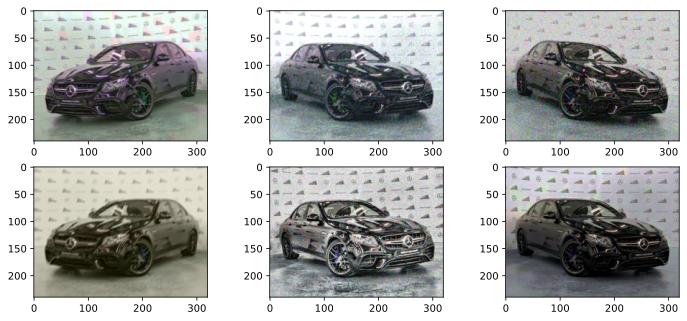

In [9]:
# an example of the use of augmentations
show_sample_augmentations(paths, augmentation)

In [14]:
preproc_cls = preproc(config, augmentation, tokenize)

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(preproc_cls.tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(preproc_cls.tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(preproc_cls.tf_process_val_dataset_element)

# checking that there are no errors (no exception will be thrown):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [ ]:
def callbacks(lr):
    checkpoint = ModelCheckpoint('../working/best_model_all.hdf5' , monitor='val_MAPE', 
                                 verbose=1, mode='min', save_best_only=True)
    earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
    reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.3, patience=5, verbose=1, 
                                  min_lr=lr/1000, mode='min')
    
    return [checkpoint, earlystop, reduce_lr]

In [ ]:
# Step 1 Model 5 Fine_tunning - train only head & begin from LR = 0.01
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_model.trainable = False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

In [ ]:
# tabular model
tabular_model = Sequential()
tabular_model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
tabular_model.add(L.Dropout(0.25))
tabular_model.add(L.Dense(512, activation="relu"))
tabular_model.add(L.Dropout(0.5))

In [ ]:
# nlp model
nlp_model  = Sequential()
nlp_model.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
nlp_model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
nlp_model.add(L.LSTM(1024, return_sequences=True))
nlp_model.add(L.Dropout(0.25))
nlp_model.add(L.LSTM(512,))
nlp_model.add(L.Dropout(0.5))
nlp_model.add(L.Dense(256, activation="relu"))
nlp_model.add(L.Dropout(0.5))

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [ ]:
# model compile & fit
LR = 0.01
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st1.hdf5')
#model.save('../working/nn_final_st1.hdf5')

In [ ]:
# Step 2 Model 5 Fine_tunning - train ~33% last layers of EfficientNetB3 & head & begin from LR = 0.005
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_model.trainable = True
fine_tune_at = int(len(efficientnet_model.layers)//1.5)
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.005
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('../input/weightsl-simple-albu-aft-st1/best_model_all_st1(simple albu).hdf5')

history = model.fit(train_dataset.batch(20),
                    epochs=100,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st2.hdf5')
#model.save('../working/nn_final_st2.hdf5')

In [ ]:
# Step 3 Model 5 Fine_tunning - train ~50% last layers of EfficientNetB3 & head & begin from LR = 0.001
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_model.trainable = True
fine_tune_at = int(len(efficientnet_model.layers)//2)
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.001
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('./best_model_all_st2.hdf5')

history = model.fit(train_dataset.batch(20),
                    epochs=100,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st3.hdf5')
#model.save('../working/nn_final_st3.hdf5')

In [ ]:
# Step 4_1 Model 5 Fine_tunning - train ~75% last layers of EfficientNetB3 & head & begin from LR = 0.0005
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_model.trainable = True
fine_tune_at = int(len(efficientnet_model.layers)//4)
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.0005
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('../working/best_model_all_st3.hdf5')

history = model.fit(train_dataset.batch(20),
                    epochs=100,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st4_1.hdf5')
#model.save('../working/nn_final_st4_1.hdf5')

In [ ]:
# Step 4_2 Model 5 Fine_tunning - train ~75% last layers of EfficientNetB3 & head & begin from LR = 0.0001
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_model.trainable = True
fine_tune_at = int(len(efficientnet_model.layers)//4)
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.0001
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('../working/best_model_all_st4_1.hdf5')

history = model.fit(train_dataset.batch(20),
                    epochs=100,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st4_2.hdf5')
#model.save('../working/nn_final_st4_2.hdf5')

In [ ]:
# Step 5_1 Image model Fine_tunning - train all layers of EfficientNetB3 & head & begin from LR = 0.00005
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_model.trainable = True

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.00005
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('../working/best_model_all_st4_2.hdf5')

history = model.fit(train_dataset.batch(20),
                    epochs=100,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st5_1.hdf5')
#model.save('../working/nn_final_st5_1.hdf5')

In [ ]:
model.load_weights('../working/best_model_all_st5_1.hdf5')
# предсказание без округления
sub_predict_nn3 = model.predict(sub_dataset.batch(20))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission_st5_1.csv', index=False)

In [ ]:
# предсказание с округлением
sub_predict_nn3 = model.predict(sub_dataset.batch(20))
sample_submission['price'] = np.round(sub_predict_nn3[:,0],-4)
sample_submission.to_csv('nn3_submission_r4_st5_1.csv', index=False)

In [ ]:
## step 6 Model 5 Fine_tunning - train all layers of EfficientNetB3 & head & change size of picture
size = (448, 336)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

In [ ]:
# more simple
augmentation = albumentations.Compose([
    albumentations.CLAHE(p=0.25, clip_limit=(1, 10), tile_grid_size=(10, 10)),
    albumentations.ChannelShuffle(p=0.25),
    albumentations.Equalize(p=0.25, mode='cv', by_channels=True),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        ],p=0.5),
    albumentations.Rotate(p=0.5, limit=(-5, 5), interpolation=2, border_mode=2)
    ])

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_model.trainable = True

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

LR = 0.000001
optimizer = tf.keras.optimizers.Adam(LR)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

callbacks_list = callbacks(lr=LR)

model.load_weights('../working/best_model_all_st5_1.hdf5')

history = model.fit(train_dataset.batch(10),
                    epochs=100,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model_all.hdf5')
model.save_weights('../working/best_model_all_st6.hdf5')
#model.save('../working/nn_final_st6.hdf5')

In [ ]:
model.load_weights('../working/best_model_all_st6.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(10))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
# предсказание без округления
sub_predict_nn3 = model.predict(sub_dataset.batch(10))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission_st6.csv', index=False)

In [ ]:
# предсказание с округлением
sub_predict_nn3_rounded = model.predict(sub_dataset.batch(10))
sample_submission['price'] = np.round(sub_predict_nn3_rounded[:,0], -4)
sample_submission.to_csv('nn3_submission_r4_st6.csv', index=False)

# Blend

In [ ]:
sub_predict_catboost = np.array(pd.read_csv('../input/best-cat-boost/catboost_submission(2).csv')['price'])
sub_predict_nn1 = np.array(pd.read_csv('../input/best-sub-nn1/nn1_submission(2).csv')['price'])
sub_predict_nn2 = np.array(pd.read_csv('../input/best-sub-nn2/nn2_submission(2)(1).csv')['price'])
sub_predict_nn3 = np.array(pd.read_csv('../input/best-sub-nn3/nn3_submission_st5_1(1).csv')['price'])

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1 + sub_predict_nn2 + sub_predict_nn3)/4
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [ ]:
sub_predict_catboost_r4 = np.array(pd.read_csv('../input/best-cat-boost/catboost_submission(2).csv')['price'])
sub_predict_nn1_r4 = np.array(pd.read_csv('../input/best-sub-nn1/nn1_submission(2).csv')['price'])
sub_predict_nn2_r4 = np.array(pd.read_csv('../input/best-sub-nn2/nn2_submission(2)(1).csv')['price'])
sub_predict_nn3_r4 = np.array(pd.read_csv('../input/best-sub-nn3/nn3_submission_st5_1(1).csv')['price'])

In [ ]:
blend_sub_predict_rounded = (sub_predict_catboost_r4 + sub_predict_nn1_r4 + sub_predict_nn2_r4 + sub_predict_nn3_r4)/4
sample_submission['price'] = blend_sub_predict_rounded
sample_submission.to_csv('blend_submission_sum_rounded.csv', index=False)

In [ ]:
blend_sub_predict_w_out_cat = (sub_predict_nn1 + sub_predict_nn2 + sub_predict_nn3)/3
sample_submission['price'] = blend_sub_predict_w_out_cat
sample_submission.to_csv('blend_submission_w_out_cat.csv', index=False)